# D - SimCLR 

## Imports

In [1]:
from utils.D_SimCLR import *

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked un

## Data

In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)

print(f"Detected Device: {device}")

Detected Device: cuda


## Inverse Distance Contrastive Loss

In [3]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
train_df = data_df.head(len(data_df) - 300)
test_df = data_df.tail(300)
del data_df

In [4]:
model_path = "models/simclr_weights_large_views_3.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM, use_adapter=False, get_distances=True)
model.load_state_dict(torch.load(model_path))
model.switch_loss(InverseDistanceContrastiveLoss(BATCH_SIZE, device))

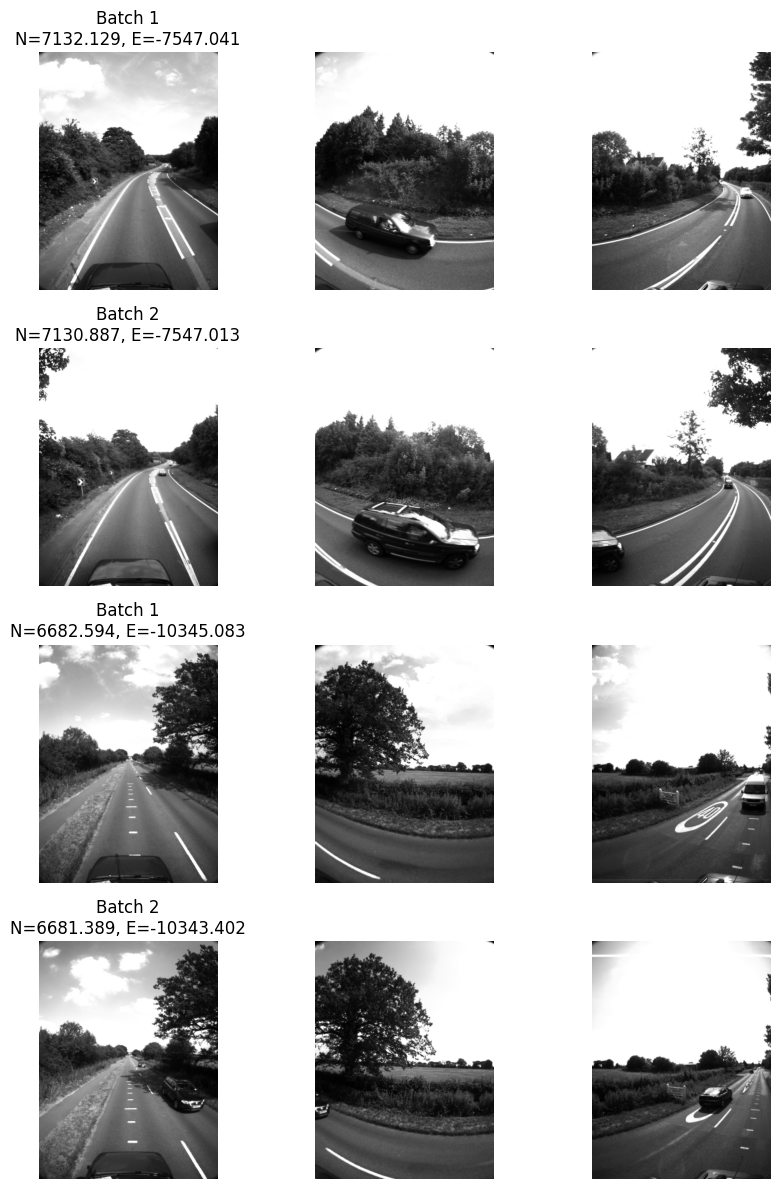

In [5]:
train_loader = get_distance_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)
plot_sample_distance_batch(train_loader, num_examples=2)
del train_loader

In [6]:
model.set_fine_tuning(True)
model.freeze_backbone()
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
transform = TestAugment(img_size=224) 
train_loader = get_distance_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)
test_loader = get_distance_loader(test_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)

accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                  accelerator='gpu',
                  devices=available_gpus,
                  max_epochs=MAX_EPOCHS)

trainer.fit(model, train_loader)
model.eval()
trainer.test(model, dataloaders=test_loader)

model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_large_views_3_inverse_distance_contrastive_loss.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene-matching/utils/SimCLR.py:486: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,

  | Name  | Type                           | Params
---------------------------------------------------------
0 | model | AddProjection                  | 11.5 M
1 | loss  | InverseDistanceContrastiveLoss | 0     
---------------------------------------------------------
296 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.893    Total estimated model params size (MB)


Backbone frozen for fine-tuning
Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 49: 100%|██████████| 66/66 [00:38<00:00,  1.73it/s, loss=2.3e+04, v_num=120, Distance-Sensitive loss_step=2.81e+4, Distance-Sensitive loss_epoch=2.24e+4] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 66/66 [00:38<00:00,  1.72it/s, loss=2.3e+04, v_num=120, Distance-Sensitive loss_step=2.81e+4, Distance-Sensitive loss_epoch=2.24e+4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric         DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Distance-Sensitive loss_epoch      22344.43847914107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model weights saved to models/simclr_weights_large_views_3_inverse_distance_contrastive_loss.pth


### Results

In [7]:
model_path = "models/simclr_weights_large_views_3_inverse_distance_contrastive_loss.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM, use_adapter=False)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

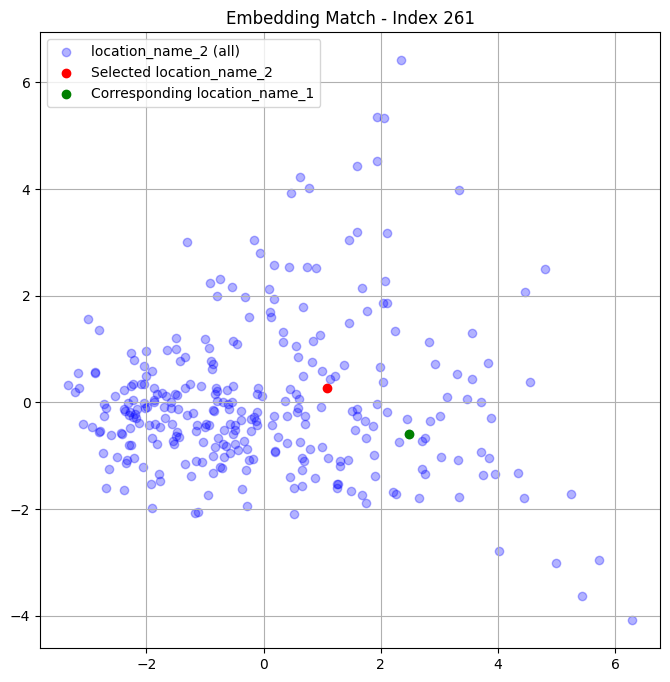

In [8]:
model.eval()
transform = TestAugment(img_size=224)
plot_embedding_match_2d_distance_loader(model, test_df.copy(), base_path='Eynsham/Images', device=device, batch_size=BATCH_SIZE, transform = transform, num_views=3)

In [9]:
top1small, top5small, top10small, distance = evaluate_embedding_accuracy_distance_loader(model, test_df, base_path='Eynsham/Images', transform=transform, num_views=3)
print(f"Accuracy for concatenated embeddings SimCLR: Top 1: {top1small*100:.4f}%, Top 5: {top5small*100:.4f}%, Top 10: {top10small*100:.4f}%, Mean Distance to target: {distance:.4f}")

Accuracy for concatenated embeddings SimCLR: Top 1: 30.6667%, Top 5: 48.0000%, Top 10: 58.3333%, Mean Distance to target: 3309.5080


## Soft Denominator Contrastive Loss

In [10]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
train_df = data_df.head(len(data_df) - 300)
test_df = data_df.tail(300)
del data_df

In [11]:
model_path = "models/simclr_weights_large_views_3.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM, use_adapter=False, get_distances=True)
model.load_state_dict(torch.load(model_path))
model.switch_loss(SoftDenominatorContrastiveLoss(BATCH_SIZE, device))

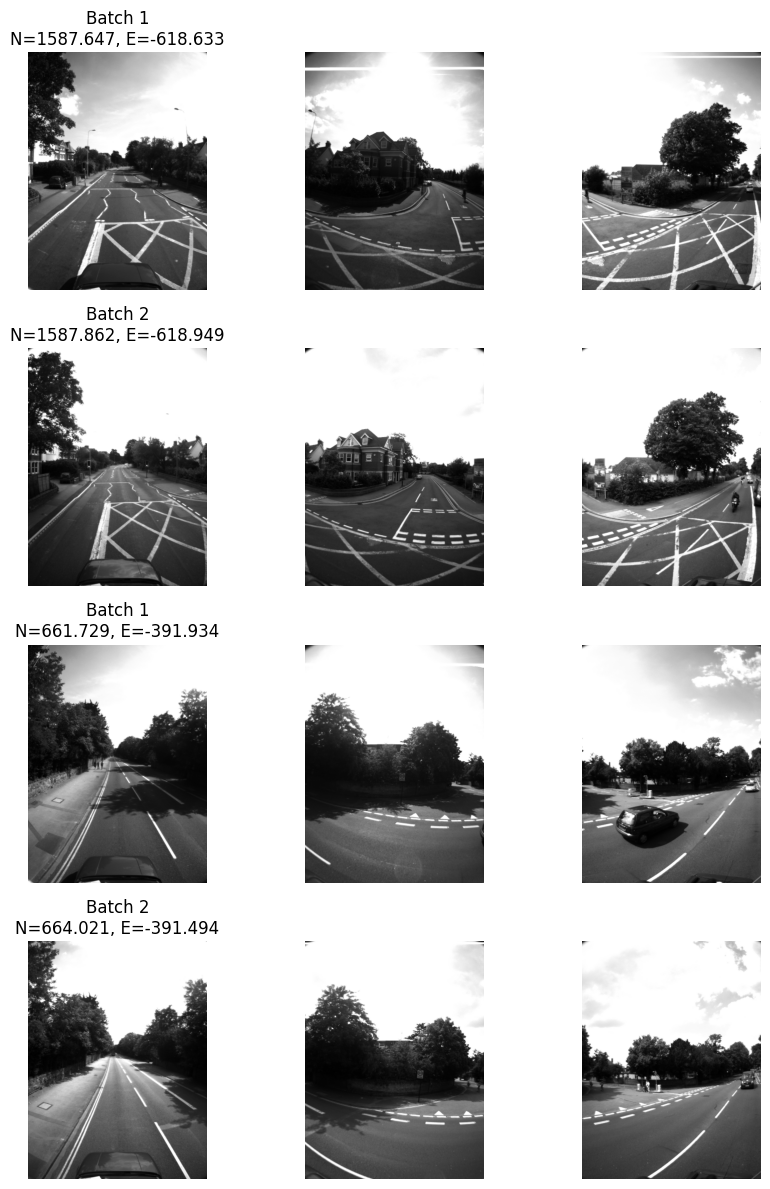

In [12]:
train_loader = get_distance_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)
plot_sample_distance_batch(train_loader, num_examples=2)
del train_loader

In [13]:
model.set_fine_tuning(True)
model.freeze_backbone()
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
transform = TestAugment(img_size=224) 
train_loader = get_distance_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)
test_loader = get_distance_loader(test_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)

accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                  accelerator='gpu',
                  devices=available_gpus,
                  max_epochs=MAX_EPOCHS)

trainer.fit(model, train_loader)
model.eval()
trainer.test(model, dataloaders=test_loader)

model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_large_views_3_soft_denominator_contrastive_loss.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene-matching/utils/SimCLR.py:486: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,

  | Name  | Type                           | Params
---------------------------------------------------------
0 | model | AddProjection                  | 11.5 M
1 | loss  | SoftDenominatorContrastiveLoss | 0     
---------------------------------------------------------
296 K     T

Backbone frozen for fine-tuning
Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 49: 100%|██████████| 66/66 [00:37<00:00,  1.75it/s, loss=2.37, v_num=121, Distance-Sensitive loss_step=1.860, Distance-Sensitive loss_epoch=2.390]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 66/66 [00:37<00:00,  1.74it/s, loss=2.37, v_num=121, Distance-Sensitive loss_step=1.860, Distance-Sensitive loss_epoch=2.390]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric         DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Distance-Sensitive loss_epoch     2.4773740257018484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model weights saved to models/simclr_weights_large_views_3_soft_denominator_contrastive_loss.pth


### Results

In [ ]:
model_path = "models/simclr_weights_large_views_3_soft_denominator_contrastive_loss.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM, use_adapter=False)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

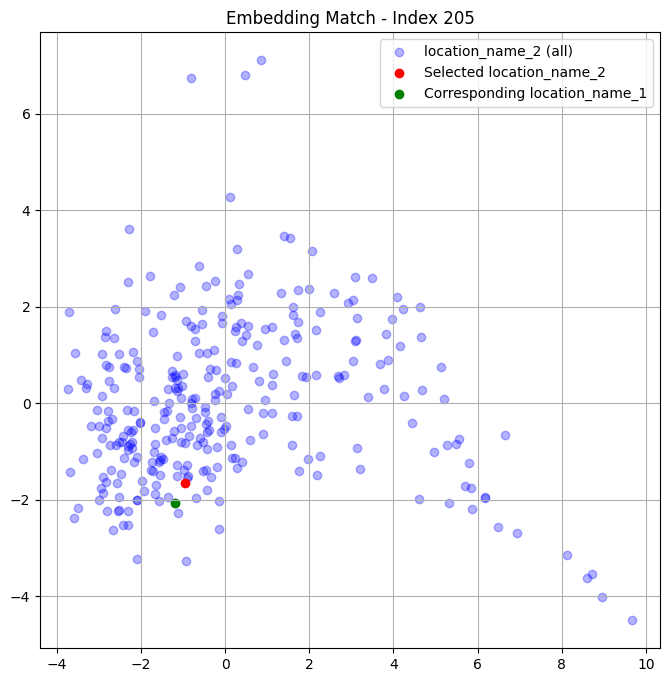

In [15]:
transform = TestAugment(img_size=224)
plot_embedding_match_2d_distance_loader(model, test_df.copy(), base_path='Eynsham/Images', device=device, batch_size=BATCH_SIZE, transform = transform, num_views=3)

In [16]:
top1small, top5small, top10small, distance = evaluate_embedding_accuracy_distance_loader(model, test_df, base_path='Eynsham/Images', transform=transform, num_views=3)
print(f"Accuracy for concatenated embeddings SimCLR: Top 1: {top1small*100:.4f}%, Top 5: {top5small*100:.4f}%, Top 10: {top10small*100:.4f}%, Mean Distance to target: {distance:.4f}")

Accuracy for concatenated embeddings SimCLR: Top 1: 34.0000%, Top 5: 50.3333%, Top 10: 60.0000%, Mean Distance to target: 3061.0299


## Tempreture Scaling Contrastive Loss

In [3]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
train_df = data_df.head(len(data_df) - 300)
test_df = data_df.tail(300)
del data_df

In [4]:
model_path = "models/simclr_weights_large_views_3.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM, use_adapter=False, get_distances=True)
model.load_state_dict(torch.load(model_path))
model.switch_loss(TemperatureScalingContrastiveLoss(BATCH_SIZE, device))

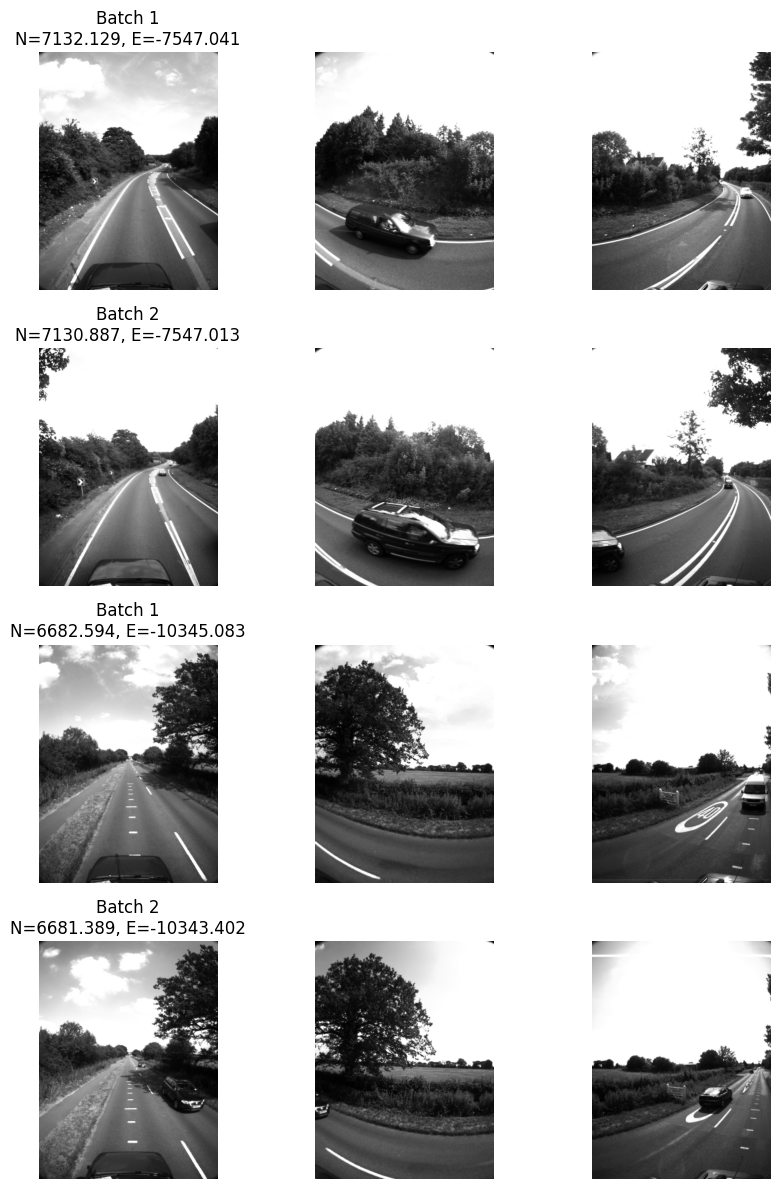

In [5]:
train_loader = get_distance_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)
plot_sample_distance_batch(train_loader, num_examples=2)
del train_loader

In [6]:
model.set_fine_tuning(True)
model.freeze_backbone()
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
transform = TestAugment(img_size=224) 
train_loader = get_distance_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)
test_loader = get_distance_loader(test_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, num_views=3)

accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                  accelerator='gpu',
                  devices=available_gpus,
                  max_epochs=MAX_EPOCHS)

trainer.fit(model, train_loader)
model.eval()
trainer.test(model, dataloaders=test_loader)

model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_large_views_3_tempreture_scaling_contrastive_loss.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene-matching/utils/SimCLR.py:487: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,

  | Name  | Type                              | Params
------------------------------------------------------------
0 | model | AddProjection                     | 11.5 M
1 | loss  | TemperatureScalingContrastiveLoss | 0     
---------------------------------------------------------

Backbone frozen for fine-tuning
Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 49: 100%|██████████| 66/66 [00:40<00:00,  1.63it/s, loss=3, v_num=132, Distance-Sensitive loss_step=1.540, Distance-Sensitive loss_epoch=3.070]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 66/66 [00:40<00:00,  1.62it/s, loss=3, v_num=132, Distance-Sensitive loss_step=1.540, Distance-Sensitive loss_epoch=3.070]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric         DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Distance-Sensitive loss_epoch     2.9661195958734474
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model weights saved to models/simclr_weights_large_views_3_tempreture_scaling_contrastive_loss.pth


### Results

In [7]:
model_path = "models/simclr_weights_large_views_3_tempreture_scaling_contrastive_loss.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM, use_adapter=False, get_distances=True)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

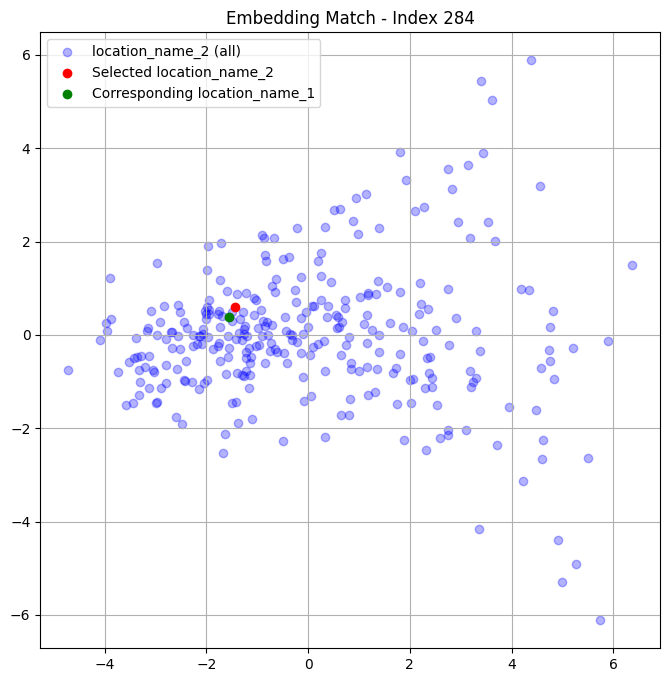

In [8]:
transform = TestAugment(img_size=224)
plot_embedding_match_2d_distance_loader(model, test_df.copy(), base_path='Eynsham/Images', device=device, batch_size=BATCH_SIZE, transform = transform, num_views=3)

In [9]:
top1small, top5small, top10small, distance = evaluate_embedding_accuracy_distance_loader(model, test_df, base_path='Eynsham/Images', transform=transform, num_views=3)
print(f"Accuracy for concatenated embeddings SimCLR: Top 1: {top1small*100:.4f}%, Top 5: {top5small*100:.4f}%, Top 10: {top10small*100:.4f}%, Mean Distance to target: {distance:.4f}")

Accuracy for concatenated embeddings SimCLR: Top 1: 25.6667%, Top 5: 43.3333%, Top 10: 53.3333%, Mean Distance to target: 3752.6307
